# Final Proyect

In [1]:
# from ultralytics import YOLO
# from glob import glob
# from pathlib import Path

# import os, cv2, re
# import numpy as np
# import xml.etree.ElementTree as ET

# Data visualization

Los datos han sido descargados de https://universe.roboflow.com/rjacaac1/ua-detrac-dataset-10k/dataset/2

Estos son archivos txt los cuales estos son los nombres de las columnas en el mismo orden en el que lo encontramos en los archivos

[class_id, center_x, center_y, width, height]

Ahora vamos a visualizar las imagenes que estan en formato jpg.

- UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/train/images/
- UA-DETRAC-DATASET-10K.v2-2024-11-14-3-48pm.yolov8/valid/images/

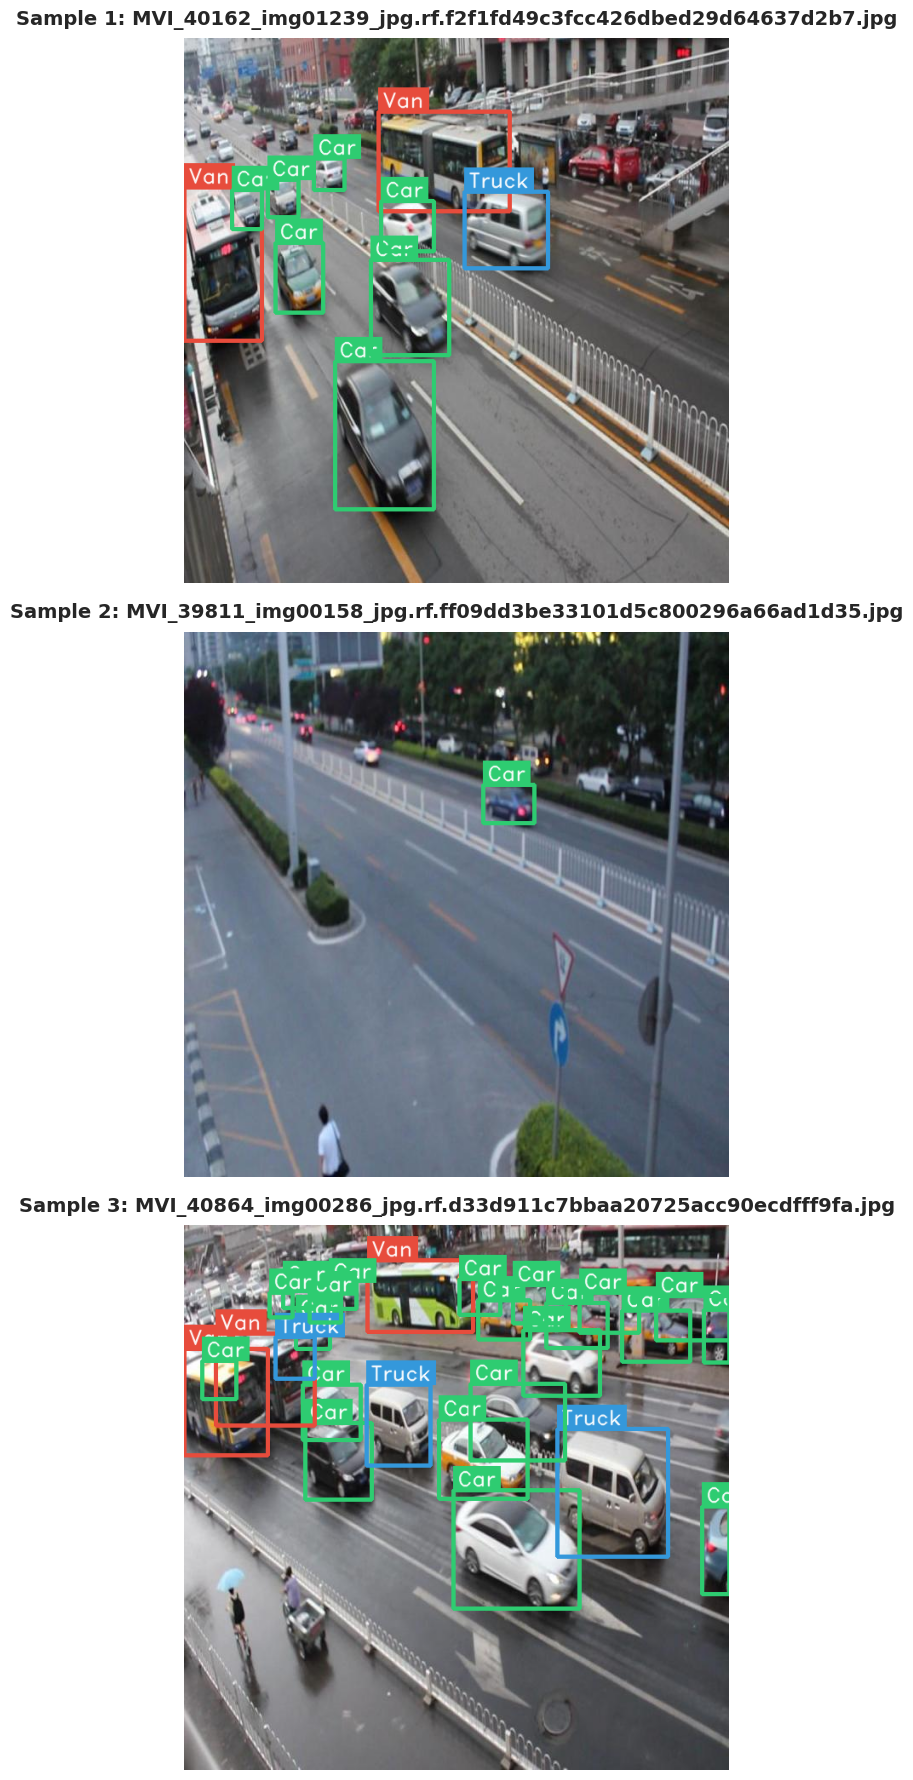

In [2]:
import cv2
import matplotlib.pyplot as plt
import os
import random
import glob
import seaborn as sns

# --- CONFIGURATION ---
base_dir = "UA-DETRAC"
subset = "train" 

img_dir = os.path.join(base_dir, subset, "images")
label_dir = os.path.join(base_dir, subset, "labels")

# UPDATED: Correct Class Mapping
class_names = {
    0: "Bus",
    1: "Car",
    2: "Truck", 
    3: "Van" 
}

# --- THEME SETUP ---
# Use a clean white theme for image grids (no gridlines needed)
sns.set_theme(style="white", context="notebook", font_scale=1.1)

# Defined "Pleasant" RGB Colors (Matching your other plots)
# Bus=Gold, Car=Green, Truck=Blue, Van=Red
class_colors = {
    0: (244, 208, 63),   # Bus (Gold)
    1: (46, 204, 113),   # Car (Emerald Green)
    2: (52, 152, 219),   # Truck (Soft Blue)
    3: (231, 76, 60)     # Van (Alizarin Red)
}

def visualize_random_samples(num_samples=3):
    img_files = glob.glob(os.path.join(img_dir, "*.jpg")) + glob.glob(os.path.join(img_dir, "*.PNG"))
    
    if not img_files:
        print(f"No images found in {img_dir}")
        return

    samples = random.sample(img_files, min(len(img_files), num_samples))

    # Create the figure
    plt.figure(figsize=(15, 6 * num_samples))

    for i, img_path in enumerate(samples):
        # Read image
        img = cv2.imread(img_path)
        if img is None: continue
        
        # Convert BGR (OpenCV) to RGB (Matplotlib)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        h, w, _ = img.shape

        # Construct label path
        filename = os.path.basename(img_path)
        label_name = os.path.splitext(filename)[0] + ".txt"
        label_path = os.path.join(label_dir, label_name)

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
                
            for line in lines:
                parts = line.strip().split()
                if len(parts) < 5: continue
                
                try:
                    cls_id = int(parts[0])
                    
                    # Extract coordinates
                    x_center, y_center = float(parts[1]), float(parts[2])
                    box_w, box_h = float(parts[3]), float(parts[4])

                    # Convert Normalized -> Pixels
                    x_min = int((x_center - box_w / 2) * w)
                    y_min = int((y_center - box_h / 2) * h)
                    x_max = int((x_center + box_w / 2) * w)
                    y_max = int((y_center + box_h / 2) * h)

                    # Get Color (Default to White if unknown)
                    color = class_colors.get(cls_id, (255, 255, 255)) 
                    label_text = class_names.get(cls_id, f"ID: {cls_id}")

                    # Draw Box (Thickness 3 for better visibility)
                    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 4)
                    
                    # Draw Text Label with Background
                    # Get text size to draw a background box exactly that size
                    (text_w, text_h), baseline = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_DUPLEX, 0.8, 1)
                    
                    # Draw filled rectangle for text background
                    cv2.rectangle(img, 
                                  (x_min, y_min - text_h - 10), 
                                  (x_min + text_w + 10, y_min), 
                                  color, -1) 
                    
                    # Draw text in White or Black depending on contrast (White usually looks clean on these colors)
                    cv2.putText(img, label_text, (x_min + 5, y_min - 5), 
                                cv2.FONT_HERSHEY_DUPLEX, 0.8, (255, 255, 255), 1, cv2.LINE_AA)
                                
                except ValueError:
                    continue
        else:
            print(f"Warning: No label file found for {filename}")

        # Plot Subplot
        plt.subplot(num_samples, 1, i + 1)
        plt.imshow(img)
        plt.axis('off') # Hide axis ticks
        plt.title(f"Sample {i+1}: {filename}", fontsize=14, fontweight='bold', pad=10)

    plt.tight_layout()
    
    # Save BEFORE show (otherwise you save a blank white image)
    plt.savefig("samples_per_class.png", dpi=300, bbox_inches='tight')
    plt.show()

visualize_random_samples(3)

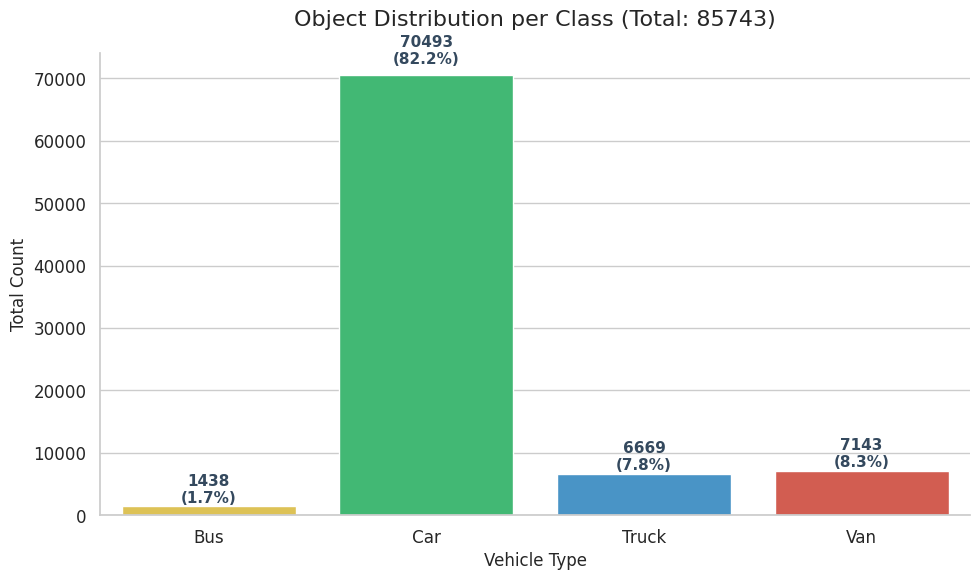

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd

# --- CONFIG ---
label_dir = "UA-DETRAC/train/labels"
txt_files = glob.glob(os.path.join(label_dir, "*.txt"))

# Class Mapping
class_names = {
    0: "Bus",
    1: "Car",
    2: "Truck",
    3: "Van"
}

# Consistent Color Palette
custom_palette = {
    "Bus":   "#F4D03F",  # Soft Gold
    "Car":   "#2ECC71",  # Emerald Green
    "Truck": "#3498DB",  # Soft Blue
    "Van":   "#E74C3C"   # Alizarin Red
}

# --- 1. SET THEME ---
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)

# 2. Collect Data
class_counts = {name: 0 for name in class_names.values()}
unknown_counts = 0

if not txt_files:
    print(f"Error: No .txt files found in {label_dir}")
else:
    for txt_file in txt_files:
        with open(txt_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if not parts: continue
                
                try:
                    cls_id = int(parts[0])
                    if cls_id in class_names:
                        class_counts[class_names[cls_id]] += 1
                    else:
                        unknown_counts += 1
                except ValueError:
                    continue

    # Calculate Total for Percentages
    total_instances = sum(class_counts.values())

    # 3. Prepare DataFrame for plotting
    df_counts = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

    # 4. Plotting
    plt.figure(figsize=(10, 6))
    
    # Create Bar Plot
    ax = sns.barplot(
        data=df_counts,
        x="Class",
        y="Count",
        hue="Class",      
        palette=custom_palette,
        legend=False      
    )
    
    # Labels and Title
    plt.title(f"Object Distribution per Class (Total: {total_instances})", fontsize=16, pad=20)
    plt.xlabel("Vehicle Type", fontsize=12)
    plt.ylabel("Total Count", fontsize=12)
    
    # Add numbers AND percentages on top of bars
    for p in ax.patches:
        height = p.get_height()
        if height > 0: # Only label if bar exists
            # Calculate Percentage
            pct = (height / total_instances) * 100
            
            # Format: "1250\n(12.5%)"
            label_text = f'{int(height)}\n({pct:.1f}%)'
            
            ax.text(
                p.get_x() + p.get_width() / 2., 
                height + (height * 0.02), # Slightly above the bar
                label_text, 
                ha="center", 
                va="bottom", 
                fontweight="bold", 
                color="#34495e", 
                fontsize=11
            )

    # Remove top and right borders
    sns.despine()
    
    plt.tight_layout()
    plt.savefig("instances_per_class.png", dpi=300, bbox_inches='tight')
    plt.show()

    if unknown_counts > 0:
        print(f"⚠️ Warning: Found {unknown_counts} objects with unknown IDs.")

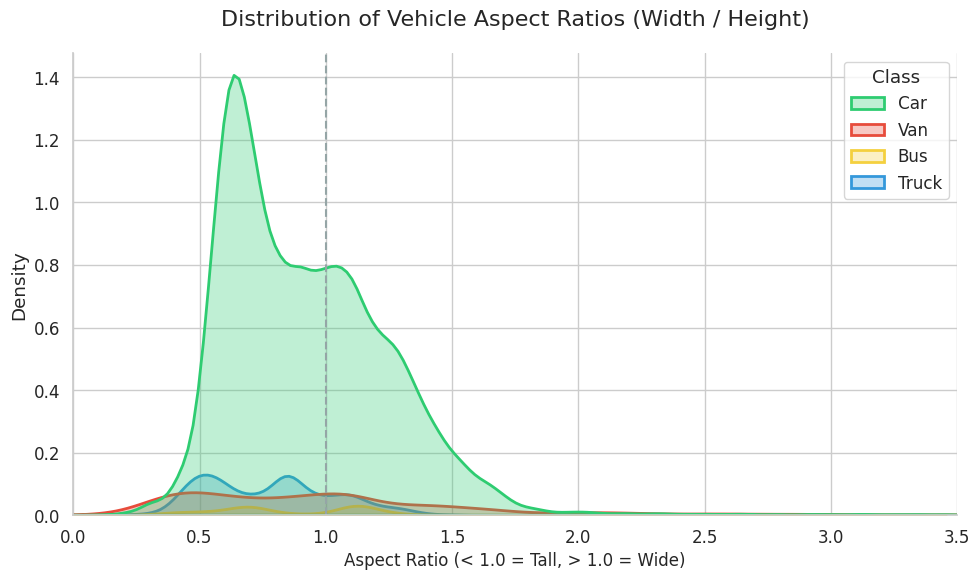

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
import numpy as np

# --- CONFIG ---
label_dir = "UA-DETRAC/train/labels"
txt_files = glob.glob(os.path.join(label_dir, "*.txt"))

class_names = {0: "Bus", 1: "Car", 2: "Truck", 3: "Van"}

custom_palette = {
    "Bus":   "#F4D03F",
    "Car":   "#2ECC71",
    "Truck": "#3498DB",
    "Van":   "#E74C3C"
}

sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)

# 1. Collect Data
data_list = []

if txt_files:
    for txt_file in txt_files:
        with open(txt_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if not parts: continue
                try:
                    cls_id = int(parts[0])
                    w, h = float(parts[3]), float(parts[4])
                    
                    if cls_id in class_names and h > 0: # Avoid division by zero
                        aspect_ratio = w / h
                        
                        # Filter out extreme outliers (e.g. bad labels) for a cleaner plot
                        if aspect_ratio < 4: 
                            data_list.append({
                                "Class": class_names[cls_id],
                                "Aspect Ratio": aspect_ratio
                            })
                except ValueError:
                    continue

    if data_list:
        df = pd.DataFrame(data_list)
        
        plt.figure(figsize=(10, 6))
        
        # Use a KDE Plot (Smooth distribution curve)
        sns.kdeplot(
            data=df, 
            x="Aspect Ratio", 
            hue="Class", 
            palette=custom_palette,
            fill=True,      # Fill area under curve
            alpha=0.3,      # Transparency
            linewidth=2
        )
        
        # Add Reference Line at 1.0 (Square)
        plt.axvline(x=1.0, color='#95a5a6', linestyle='--', label='Square (1:1)')
        
        plt.title("Distribution of Vehicle Aspect Ratios (Width / Height)", fontsize=16, pad=20)
        plt.xlabel("Aspect Ratio (< 1.0 = Tall, > 1.0 = Wide)", fontsize=12)
        plt.xlim(0, 3.5) # Limit x-axis to focus on common shapes
        
        # Remove borders
        sns.despine()
        
        plt.tight_layout()
        plt.savefig("bb_distribution_ratios.png", dpi=300)
        plt.show()

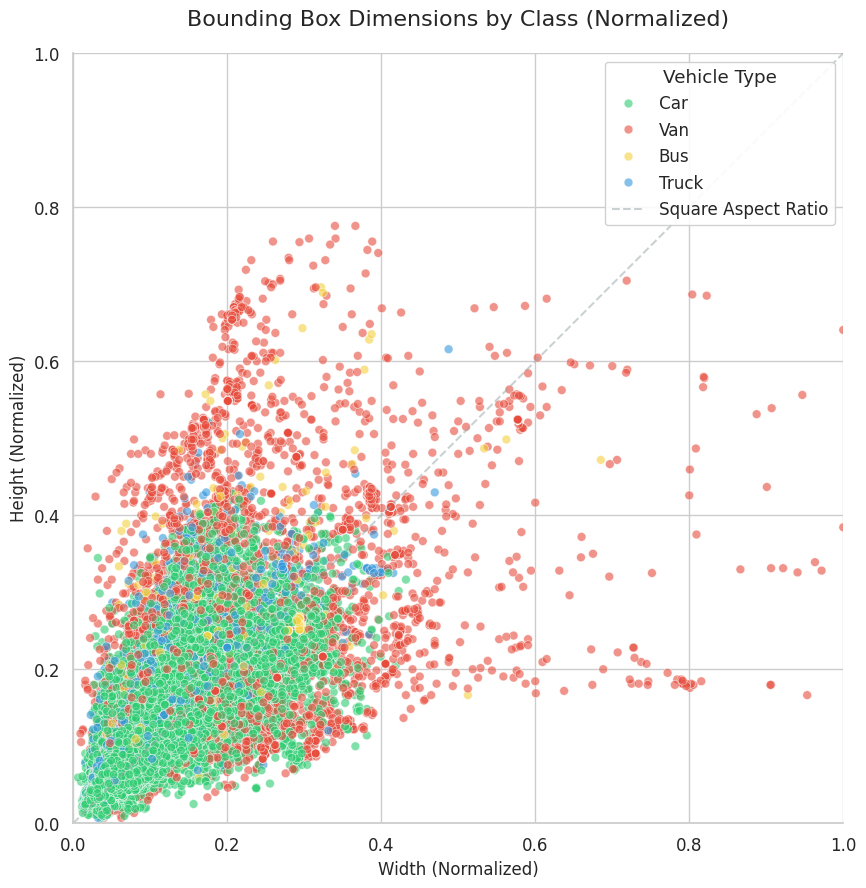

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd

# --- CONFIGURATION ---
label_dir = "UA-DETRAC/train/labels"
txt_files = glob.glob(os.path.join(label_dir, "*.txt"))

# Your specific class mapping
class_names = {
    0: "Bus",
    1: "Car",
    2: "Truck", 
    3: "Van" 
}

# Define a "Pleasant" Color Palette (Flat UI Colors)
# Bus=Yellow/Gold, Car=Green/Teal, Truck=Blue, Van=Red/Coral
custom_palette = {
    "Bus":   "#F4D03F",  # Soft Gold
    "Car":   "#2ECC71",  # Emerald Green
    "Truck": "#3498DB",  # Soft Blue
    "Van":   "#E74C3C"   # Alizarin Red
}

# --- 1. SET THEME ---
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)

# 2. Collect Data
data_list = []

if not txt_files:
    print(f"Error: No .txt files found in {label_dir}")
else:
    for txt_file in txt_files:
        with open(txt_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if not parts: continue
                
                try:
                    cls_id = int(parts[0])
                    w, h = float(parts[3]), float(parts[4])
                    
                    if cls_id in class_names:
                        data_list.append({
                            "Class": class_names[cls_id],
                            "Width": w,
                            "Height": h
                        })
                except ValueError:
                    continue

    # 3. Plotting
    if data_list:
        df = pd.DataFrame(data_list)
        
        plt.figure(figsize=(10, 10))
        
        # Create Scatter Plot
        # alpha=0.6 makes overlapping points see-through (helps visualize density)
        ax = sns.scatterplot(
            data=df,
            x="Width",
            y="Height",
            hue="Class",
            palette=custom_palette,
            s=40,           # Dot size
            alpha=0.6,      # Transparency
            edgecolor="w",  # White border around dots for "pop"
            linewidth=0.5
        )

        # Labels and Title
        plt.title("Bounding Box Dimensions by Class (Normalized)", fontsize=16, pad=20)
        plt.xlabel("Width (Normalized)", fontsize=12)
        plt.ylabel("Height (Normalized)", fontsize=12)
        
        # Set Limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        
        # Add diagonal line (Reference for Square shapes)
        plt.plot([0, 1], [0, 1], color='#95a5a6', linestyle='--', alpha=0.5, label='Square Aspect Ratio')
        
        # Clean up the Legend
        plt.legend(title="Vehicle Type", loc='upper right', frameon=True, framealpha=0.9)
        
        # Remove top/right borders
        sns.despine()
        
        # Force a square aspect ratio for the plot itself (so x=0.5 and y=0.5 look equal)
        plt.gca().set_aspect('equal', adjustable='box')

        plt.savefig("bb_dimensions.png", dpi=300, bbox_inches='tight')
        
        plt.show()
    else:
        print("No valid data found to plot.")

**Distribution of bounding box size by class**

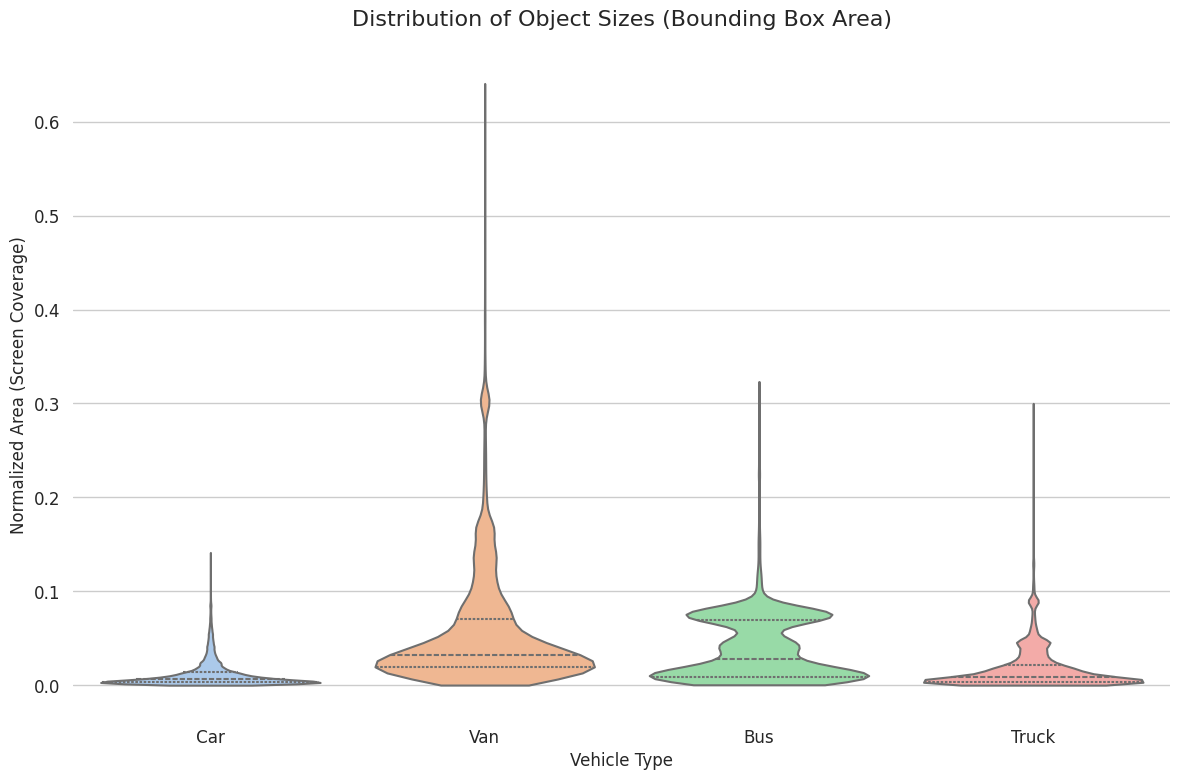

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd

# --- CONFIGURATION ---
label_dir = "UA-DETRAC/train/labels"
txt_files = glob.glob(os.path.join(label_dir, "*.txt"))

class_names = {
    0: "Bus",
    1: "Car",
    2: "Truck", 
    3: "Van" 
}

# --- 1. SET THEME ---
# "whitegrid" adds horizontal lines for easier reading
# "pastel" gives softer, less aggressive colors
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.1)

# 2. Collect Data
data_list = []

if not txt_files:
    print(f"Error: No .txt files found in {label_dir}")
else:
    for txt_file in txt_files:
        with open(txt_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if not parts: continue
                
                try:
                    cls_id = int(parts[0])
                    w, h = float(parts[3]), float(parts[4])
                    area = w * h
                    
                    if cls_id in class_names:
                        data_list.append({
                            "Class": class_names[cls_id],
                            "Area": area
                        })
                except ValueError:
                    continue

    # 3. Plotting
    if data_list:
        df = pd.DataFrame(data_list)
        
        plt.figure(figsize=(12, 8))
        
        # Create Violin Plot
        # cut=0: Limits the violin to the actual data range (doesn't guess negative values)
        # inner="box": Shows a mini boxplot inside (median + quartiles)
        ax = sns.violinplot(
            data=df, 
            x="Class", 
            y="Area", 
            hue="Class",      # Redundant but required for palette mapping in new versions
            legend=False,     # Hide legend since X-axis labels are enough
            palette="pastel", 
            cut=0,
            inner="quart",    # Draws lines at 25%, 50%, 75%
            linewidth=1.5
        )
        
        # Add a title and cleaner labels
        plt.title("Distribution of Object Sizes (Bounding Box Area)", fontsize=16, pad=20)
        plt.ylabel("Normalized Area (Screen Coverage)", fontsize=12)
        plt.xlabel("Vehicle Type", fontsize=12)
        
        # Remove the top and right spines (borders) for a cleaner "Tufte" look
        sns.despine(left=True, bottom=True)
        
        plt.tight_layout()
        plt.savefig("bb_size_violin.png", dpi=300, bbox_inches='tight')
        plt.show()
        
    else:
        print("No valid data found to plot.")

# Data Preprocessing

# Speed detection

**1. Confirm correct loading**

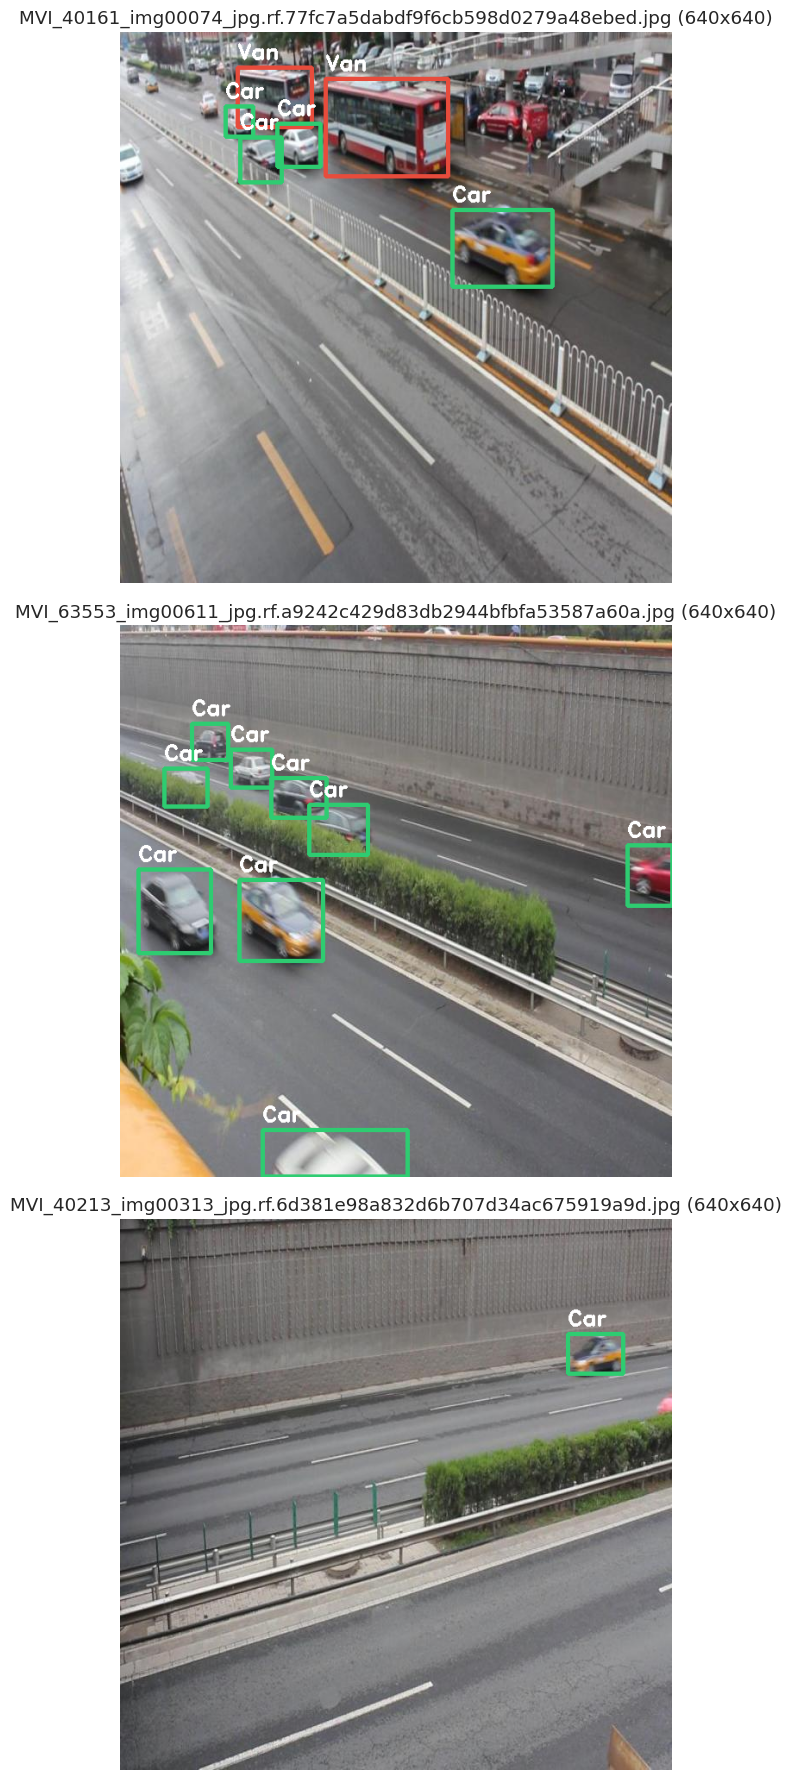

In [7]:
import cv2
import matplotlib.pyplot as plt
import os
import random
import glob
import seaborn as sns

# --- CONFIGURATION ---
# Pointing to your NEW folder structure
base_dir = "UA-DETRAC"
subset = "train" 

img_dir = os.path.join(base_dir, subset, "images")
label_dir = os.path.join(base_dir, subset, "labels")

# CLASSES from your data.yaml
class_names = {
    0: "Bus",
    1: "Car",
    2: "Truck", 
    3: "Van" 
}

# Theme Setup
sns.set_theme(style="white", context="notebook", font_scale=1.1)
class_colors = {
    0: (244, 208, 63),   # Bus (Gold)
    1: (46, 204, 113),   # Car (Emerald Green)
    2: (52, 152, 219),   # Truck (Soft Blue)
    3: (231, 76, 60)     # Van (Red)
}

def visualize_roboflow_data(num_samples=3):
    # Roboflow usually exports jpg, but we check both just in case
    img_files = glob.glob(os.path.join(img_dir, "*.jpg")) + glob.glob(os.path.join(img_dir, "*.jpeg"))
    
    if not img_files:
        print(f"Error: No images found in {img_dir}. Check your path!")
        return

    samples = random.sample(img_files, min(len(img_files), num_samples))
    plt.figure(figsize=(15, 6 * num_samples))

    for i, img_path in enumerate(samples):
        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        h, w, _ = img.shape

        filename = os.path.basename(img_path)
        label_path = os.path.join(label_dir, os.path.splitext(filename)[0] + ".txt")

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) < 5: continue
                    cls_id = int(parts[0])
                    
                    # YOLO Parsing
                    x_c, y_c, bw, bh = map(float, parts[1:5])
                    x_min = int((x_c - bw/2) * w)
                    y_min = int((y_c - bh/2) * h)
                    x_max = int((x_c + bw/2) * w)
                    y_max = int((y_c + bh/2) * h)

                    color = class_colors.get(cls_id, (200, 200, 200))
                    label = class_names.get(cls_id, "Unknown")
                    
                    # Draw
                    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 3)
                    cv2.putText(img, label, (x_min, y_min - 10), 
                                cv2.FONT_HERSHEY_DUPLEX, 0.8, (255,255,255), 2)
        
        plt.subplot(num_samples, 1, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{filename} (640x640)") # Roboflow resizes to 640

    plt.tight_layout()
    plt.show()

visualize_roboflow_data(3)

# Training

In [8]:
!uv pip install ultralytics

Using Python 3.13.7 environment at: /home/alumno/py313ml/.venv
Audited 1 package in 18ms


In [10]:
from ultralytics import YOLO
import os

# Get absolute path to your data.yaml to avoid path errors
yaml_path = os.path.abspath("UA-DETRAC/data.yaml")

# Load model
model = YOLO('yolov8n.pt') 

# Train
results = model.train(
    data=yaml_path,
    epochs=10,        # Adjust as needed
    imgsz=640,        # Dataset is already 640x640
    batch=16,
    name='ua_detrac_run',
    seed=42,
    deterministic=True,
    workers=2
)

Ultralytics 8.3.238 🚀 Python-3.13.7 torch-2.8.0+cu128 CUDA:0 (NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition, 97248MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/alumno/Desktop/datos/Computer Vision/Final Project/UA-DETRAC/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ua_detrac_run4, nbs=64, nms=False, opset=Non

**INFERENCE**

Loading model and calculating metrics...
Ultralytics 8.3.238 🚀 Python-3.13.7 torch-2.8.0+cu128 CUDA:0 (NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition, 97248MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 213.3±72.2 MB/s, size: 54.7 KB)
val: Scanning /home/alumno/Desktop/datos/Computer Vision/Final Project/UA-DETRAC/valid/labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 500/500 126.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 32/32 7.1it/s 4.5s<0.2s
                   all        500       4845      0.925      0.905      0.956      0.849
                   bus         94         96      0.953      0.845      0.941      0.819
                   car        500       4103      0.951      0.934      0.974      0.842
                 truck        135        188      0.855      0.875      0.925      0.8

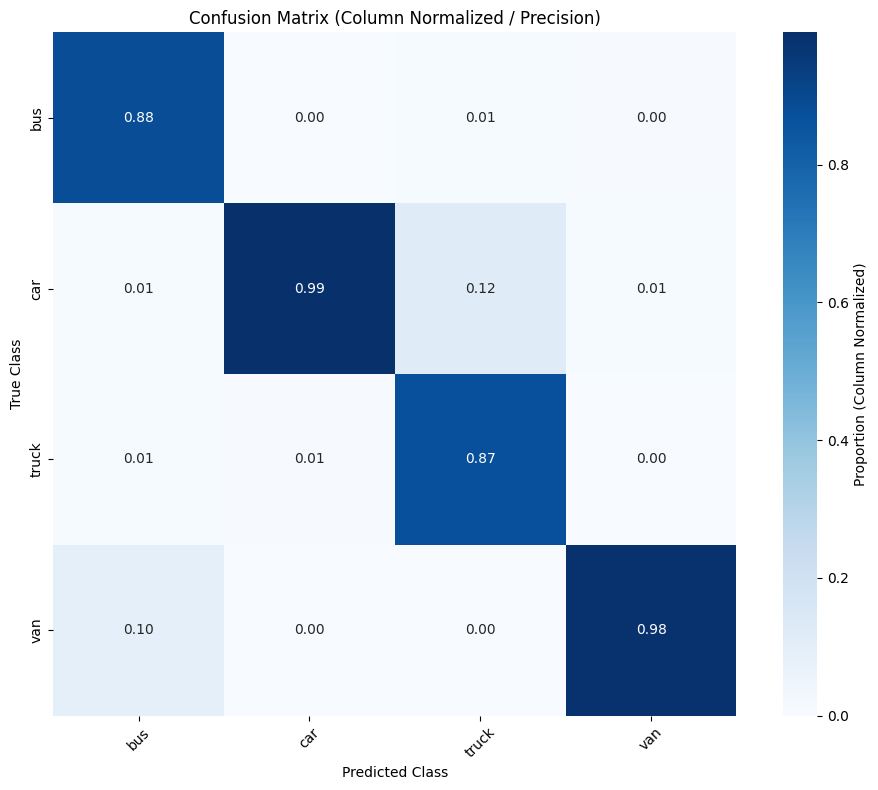


--- SUCCESS ---
Column-normalized matrix saved to:
/home/alumno/Desktop/datos/Computer Vision/Final Project/runs/detect/val10/confusion_matrix_column_norm.png

--- Precision per Class (Diagonal values) ---
bus: 0.88
car: 0.99
truck: 0.87
van: 0.98


In [17]:
from ultralytics import YOLO
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# --- CONFIGURATION ---
model_path = 'runs/detect/ua_detrac_run4/weights/best.pt' 
yaml_path = os.path.abspath("UA-DETRAC/data.yaml")

# --- EXECUTION ---
model = YOLO(model_path)

print("Loading model and calculating metrics...")

# Run Validation
# We set plots=False because we will generate our own custom plot
metrics = model.val(
    data=yaml_path, 
    split='val', 
    # plots=False, 
    conf=0.25
)

# --- CUSTOM MATRIX GENERATION ---

# 1. Get the Raw Confusion Matrix
# YOLO stores the raw counts in this attribute
raw_cm = metrics.confusion_matrix.matrix

# 2. Handle Class Names
# The raw matrix often includes a 'background' row/col at the end.
# We slice it to match the number of actual classes defined in your model.
names = list(model.names.values())
n = len(names)
cm = raw_cm[0:n, 0:n] 

# 3. NORMALIZE BY COLUMN (Precision)
# axis=0 sums down the vertical column
col_sums = cm.sum(axis=0)

# Safety: Replace 0s with 1s to avoid division by zero errors
col_sums[col_sums == 0] = 1 

# Divide every cell by its column total
cm_norm_col = cm / col_sums[np.newaxis, :]

# 4. Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_norm_col, 
    annot=True,            # Show the numbers
    fmt='.2f',             # Format as decimals (e.g., 0.85)
    cmap='Blues',          # Blue color scheme
    xticklabels=names,     # Predicted labels (X-axis)
    yticklabels=names,     # True labels (Y-axis)
    square=True,
    cbar_kws={'label': 'Proportion (Column Normalized)'}
)

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix (Column Normalized / Precision)")
plt.xticks(rotation=45)
plt.tight_layout()

# Save the custom plot
output_file = os.path.join(metrics.save_dir, 'confusion_matrix_column_norm.png')
plt.savefig(output_file)
plt.show()

print(f"\n--- SUCCESS ---")
print(f"Column-normalized matrix saved to:\n{output_file}")

# Optional: Print the diagonal (Precision per class)
print("\n--- Precision per Class (Diagonal values) ---")
for i, name in enumerate(names):
    print(f"{name}: {cm_norm_col[i, i]:.2f}")

**The only two elements outside of the diagonal with values >0.01 are predicting truck when it's actually car (0.12) and predicting bus when it's actually van (0.10).**

**First step to fix it: Train-time augmentation**

In [19]:
from ultralytics import YOLO
import os

# Get absolute path to your data.yaml
yaml_path = os.path.abspath("UA-DETRAC/data.yaml")

# 1. Load standard COCO model (Fresh start is best for fixing logic errors)
model = YOLO('yolov8n.pt') 

# 2. Train with "Confusion Busting" Hyperparameters
results = model.train(
    data=yaml_path,
    epochs=15,             # Increased from 10 -> 15 (Augmentation makes learning harder, so it needs more time)
    imgsz=640,
    batch=16,
    name='ua_detrac_fixed',
    seed=42,
    deterministic=True,
    workers=4,
    
    # --- THE CRITICAL FIXES ---
    
    # A. FIX CAR vs TRUCK (Size Bias)
    # Default is 0.5. We raise it to 0.8.
    # This zooms images in/out drastically. The model will see "huge cars" 
    # that look like trucks, and learn they are still cars.
    scale=0.8,             
    
    # B. FIX VAN vs BUS (Shape/Orientation)
    # Add slight rotation (+/- 5 degrees).
    # This prevents the model from memorizing just the rigid outline of a bus.
    degrees=5.0,           
    
    # C. General Robustness
    fliplr=0.5,            # Flip left/right (Standard)
    mosaic=1.0,            # Ensure mosaic is ON (Standard, mixes 4 images)
)

New https://pypi.org/project/ultralytics/8.3.240 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.238 🚀 Python-3.13.7 torch-2.8.0+cu128 CUDA:0 (NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition, 97248MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/alumno/Desktop/datos/Computer Vision/Final Project/UA-DETRAC/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8

**New inference results**

Loading model and calculating metrics...
Ultralytics 8.3.238 🚀 Python-3.13.7 torch-2.8.0+cu128 CUDA:0 (NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition, 97248MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 106.7±15.3 MB/s, size: 56.7 KB)
val: Scanning /home/alumno/Desktop/datos/Computer Vision/Final Project/UA-DETRAC/valid/labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 500/500 833.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 32/32 9.6it/s 3.3s<0.1s
                   all        500       4845      0.937      0.892      0.954      0.813
                   bus         94         96      0.941      0.865      0.955      0.783
                   car        500       4103      0.961      0.913      0.972      0.815
                 truck        135        188      0.893      0.824      0.903      0.7

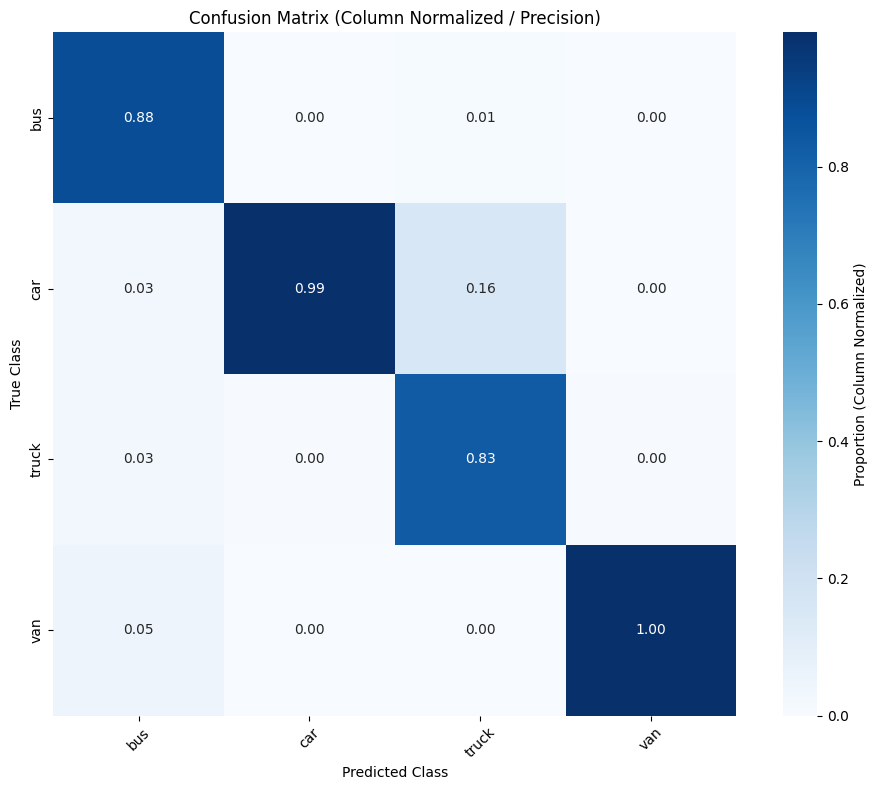


--- SUCCESS ---
Column-normalized matrix saved to:
/home/alumno/Desktop/datos/Computer Vision/Final Project/runs/detect/val11/confusion_matrix_column_norm.png

--- Precision per Class (Diagonal values) ---
bus: 0.88
car: 0.99
truck: 0.83
van: 1.00


In [20]:
from ultralytics import YOLO
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# --- CONFIGURATION ---
model_path = 'runs/detect/ua_detrac_fixed/weights/best.pt' 
yaml_path = os.path.abspath("UA-DETRAC/data.yaml")

# --- EXECUTION ---
model = YOLO(model_path)

print("Loading model and calculating metrics...")

# Run Validation
# We set plots=False because we will generate our own custom plot
metrics = model.val(
    data=yaml_path, 
    split='val', 
    # plots=False, 
    conf=0.25
)

# --- CUSTOM MATRIX GENERATION ---

# 1. Get the Raw Confusion Matrix
# YOLO stores the raw counts in this attribute
raw_cm = metrics.confusion_matrix.matrix

# 2. Handle Class Names
# The raw matrix often includes a 'background' row/col at the end.
# We slice it to match the number of actual classes defined in your model.
names = list(model.names.values())
n = len(names)
cm = raw_cm[0:n, 0:n] 

# 3. NORMALIZE BY COLUMN (Precision)
# axis=0 sums down the vertical column
col_sums = cm.sum(axis=0)

# Safety: Replace 0s with 1s to avoid division by zero errors
col_sums[col_sums == 0] = 1 

# Divide every cell by its column total
cm_norm_col = cm / col_sums[np.newaxis, :]

# 4. Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_norm_col, 
    annot=True,            # Show the numbers
    fmt='.2f',             # Format as decimals (e.g., 0.85)
    cmap='Blues',          # Blue color scheme
    xticklabels=names,     # Predicted labels (X-axis)
    yticklabels=names,     # True labels (Y-axis)
    square=True,
    cbar_kws={'label': 'Proportion (Column Normalized)'}
)

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix (Column Normalized / Precision)")
plt.xticks(rotation=45)
plt.tight_layout()

# Save the custom plot
output_file = os.path.join(metrics.save_dir, 'confusion_matrix_column_norm.png')
plt.savefig(output_file)
plt.show()

print(f"\n--- SUCCESS ---")
print(f"Column-normalized matrix saved to:\n{output_file}")

# Optional: Print the diagonal (Precision per class)
print("\n--- Precision per Class (Diagonal values) ---")
for i, name in enumerate(names):
    print(f"{name}: {cm_norm_col[i, i]:.2f}")

The track-van error has mostly been solved (0.1 to 0.05). However, the precision for the bus is still the same (0.88). The model now confuses vans and trucks even more (0.12 to 0.16) and the precision for truck has lowered from 0.87 to 0.83. The class van has now perfect precision (0.99 to 1) and car stays close to perfect too (0.99)

**VIDEO GENERATION (INITIAL)**

In [11]:
# import cv2
# import os
# import glob

# # --- CONFIGURATION ---
# # Path to your images (Update this to your actual folder)
# image_folder = 'UA-DETRAC/train/images'
# output_video_file = 'ua_detrac_test_video.mp4'
# fps = 25  # UA-DETRAC is originally 25 frames per second

# # 1. Get all image files
# # We sort them to ensure they are in the correct order (img001, img002...)
# images = sorted(glob.glob(os.path.join(image_folder, "*.jpg")))

# if not images:
#     print(f"Error: No images found in {image_folder}")
#     exit()

# # 2. Read the first image to determine video frame size
# frame = cv2.imread(images[0])
# height, width, layers = frame.shape
# size = (width, height)

# print(f"Found {len(images)} images. Creating video with resolution: {size}")

# # 3. Initialize VideoWriter
# # 'mp4v' is a standard codec for .mp4 files
# out = cv2.VideoWriter(output_video_file, cv2.VideoWriter_fourcc(*'mp4v'), fps, size)

# # 4. Write images to video
# for i, filename in enumerate(images):
#     img = cv2.imread(filename)
#     out.write(img)
    
#     # Optional: Show progress every 100 frames
#     if i % 100 == 0:
#         print(f"Processed {i}/{len(images)} frames...")

# # 5. Release and Finish
# out.release()
# print(f"Done! Video saved as {output_video_file}")

Found 9316 images. Creating video with resolution: (640, 640)
Processed 0/9316 frames...
Processed 100/9316 frames...
Processed 200/9316 frames...
Processed 300/9316 frames...
Processed 400/9316 frames...
Processed 500/9316 frames...
Processed 600/9316 frames...
Processed 700/9316 frames...
Processed 800/9316 frames...
Processed 900/9316 frames...
Processed 1000/9316 frames...
Processed 1100/9316 frames...
Processed 1200/9316 frames...
Processed 1300/9316 frames...
Processed 1400/9316 frames...
Processed 1500/9316 frames...
Processed 1600/9316 frames...
Processed 1700/9316 frames...
Processed 1800/9316 frames...
Processed 1900/9316 frames...
Processed 2000/9316 frames...
Processed 2100/9316 frames...
Processed 2200/9316 frames...
Processed 2300/9316 frames...
Processed 2400/9316 frames...
Processed 2500/9316 frames...
Processed 2600/9316 frames...
Processed 2700/9316 frames...
Processed 2800/9316 frames...
Processed 2900/9316 frames...
Processed 3000/9316 frames...
Processed 3100/9316 

**VIDEO GENERATION (FIXED FOR ACTUAL FPS, MISSING FRAMES)**

In [3]:
import cv2
import os
import glob
import numpy as np
import re  # <--- NEW: Import Regex to handle complex filenames

# --- CONFIGURATION ---
image_folder = 'UA-DETRAC/train/images'
output_video_file = 'ua_detrac_corrected.mp4'
original_real_fps = 25

# 1. Get and Sort Images
images = sorted(glob.glob(os.path.join(image_folder, "*.jpg")))

if not images:
    print(f"Error: No images found in {image_folder}")
    exit()

# 2. Extract Frame Numbers Robustly
indices = []
print(f"Analyzing {len(images)} files to detect frame gaps...")

# Pattern: Look for 'img' followed strictly by digits
# Example: matches '00001' from '_20011_img00001_jpg.rf...'
pattern = re.compile(r"img(\d+)") 

for filename in images:
    match = pattern.search(filename)
    if match:
        # distinct number found (e.g., 1)
        indices.append(int(match.group(1))) 
    else:
        # Fallback if pattern not found (unlikely)
        indices.append(0)

# 3. Calculate True FPS
if len(indices) > 1:
    # Calculate difference between every frame
    gaps = np.diff(indices)
    
    # Filter out negative gaps (which happen if multiple video clips are mixed in one folder)
    # We only care about positive gaps (forward time)
    valid_gaps = gaps[gaps > 0]
    
    if len(valid_gaps) > 0:
        # Use MEDIAN to find the common step size (ignores jumps between different video clips)
        avg_gap = np.median(valid_gaps)
    else:
        avg_gap = 1
        
    if avg_gap < 1: avg_gap = 1 # Safety
    
    calculated_fps = original_real_fps / avg_gap
    print(f"-> Detected Common Gap: {int(avg_gap)} frames")
    print(f"-> New Playback FPS: {calculated_fps:.2f}")

else:
    print("Not enough frames to calculate gap. Defaulting to 25.")
    calculated_fps = 25

# 4. Write Video
frame = cv2.imread(images[0])
height, width, layers = frame.shape
size = (width, height)

out = cv2.VideoWriter(output_video_file, cv2.VideoWriter_fourcc(*'mp4v'), calculated_fps, size)

print(f"Writing video...")
for i, filename in enumerate(images):
    img = cv2.imread(filename)
    out.write(img)
    if i % 500 == 0: print(f"Encoded {i}/{len(images)} frames")

out.release()
print(f"Done! Saved as {output_video_file}")

Analyzing 9316 files to detect frame gaps...
-> Detected Common Gap: 10 frames
-> New Playback FPS: 2.50
Writing video...
Encoded 0/9316 frames
Encoded 500/9316 frames
Encoded 1000/9316 frames
Encoded 1500/9316 frames
Encoded 2000/9316 frames
Encoded 2500/9316 frames
Encoded 3000/9316 frames
Encoded 3500/9316 frames
Encoded 4000/9316 frames
Encoded 4500/9316 frames
Encoded 5000/9316 frames
Encoded 5500/9316 frames
Encoded 6000/9316 frames
Encoded 6500/9316 frames
Encoded 7000/9316 frames
Encoded 7500/9316 frames
Encoded 8000/9316 frames
Encoded 8500/9316 frames
Encoded 9000/9316 frames
Done! Saved as ua_detrac_corrected.mp4


**Dynamic speed**

In [24]:
# import cv2
# import math
# import numpy as np
# from ultralytics import YOLO
# from collections import defaultdict
# from tqdm import tqdm  # <--- NEW: Import progress bar library

# # --- CONFIGURATION ---
# video_path = "ua_detrac_test_video.mp4"
# model_path = "runs/detect/ua_detrac_run4/weights/best.pt"
# output_path = "speed_result_dynamic.avi"

# # TUNING PARAMETERS
# frame_window = 5          # Frames to compare for speed
# meters_per_pixel = 0.05   # Adjust this to calibrate (Lower = slower speeds)

# # 1. Load Resources
# cap = cv2.VideoCapture(video_path)
# model = YOLO(model_path)

# # Get video properties
# w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# fps = int(cap.get(cv2.CAP_PROP_FPS))
# if fps == 0: fps = 25

# # <--- NEW: Get total frames for the progress bar
# total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
# track_history = defaultdict(list)

# print(f"Processing {total_frames} frames at {fps} FPS...")

# # <--- NEW: Wrap the loop in tqdm for the progress bar
# with tqdm(total=total_frames, unit="frame") as pbar:
#     while cap.isOpened():
#         success, frame = cap.read()
        
#         if not success:
#             break

#         # 3. Run Tracking
#         results = model.track(frame, persist=True, verbose=False)
        
#         if results[0].boxes.id is not None:
#             boxes = results[0].boxes.xywh.cpu()
#             track_ids = results[0].boxes.id.int().cpu().tolist()
            
#             # Plot the boxes
#             annotated_frame = results[0].plot()

#             for box, track_id in zip(boxes, track_ids):
#                 x, y, w_box, h_box = box
#                 center = (float(x), float(y))
                
#                 track = track_history[track_id]
#                 track.append(center)
                
#                 if len(track) > 30: 
#                     track.pop(0)

#                 # 4. Calculate Speed
#                 if len(track) > frame_window:
#                     p1 = track[-1]
#                     p2 = track[-1 - frame_window]
                    
#                     distance_pixels = math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
#                     distance_meters = distance_pixels * meters_per_pixel
                    
#                     # Time calculation
#                     time_seconds = frame_window / fps
                    
#                     speed_kph = (distance_meters / time_seconds) * 3.6
                    
#                     # Label Logic
#                     label = f"{int(speed_kph)} km/h"
#                     if speed_kph < 2.0: # Filter low noise
#                         label = "0 km/h"

#                     # Draw text
#                     cv2.putText(annotated_frame, label, (int(x - w_box/2), int(y - h_box/2) - 10),
#                                 cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

#             out.write(annotated_frame)
#         else:
#             out.write(frame)

#         # <--- NEW: Update the progress bar by 1 step
#         pbar.update(1)

# cap.release()
# out.release()
# cv2.destroyAllWindows()
# print(f"\nDone! Output saved to {output_path}")

Processing 9316 frames at 25 FPS...


100%|████████████████████████████████████| 9316/9316 [06:27<00:00, 24.05frame/s]


Done! Output saved to speed_result_dynamic.avi


**Previous video updated confidence but didn't show speed**

In [10]:
import cv2
import math
import numpy as np
import re
import os
import glob
from ultralytics import YOLO
from collections import defaultdict
from tqdm import tqdm 

# --- CONFIGURATION ---
# Use the folder path so we can calculate the gaps
image_folder = 'UA-DETRAC/train/images'
model_path = "runs/detect/ua_detrac_run4/weights/best.pt"
output_path = "speed_result_auto_fps.avi"

# TUNING PARAMETERS
frame_window = 5          
meters_per_pixel = 0.05   
base_capture_fps = 25.0   # The original capture rate of the camera

# 1. Load & Analyze Images
images = sorted(glob.glob(os.path.join(image_folder, "*.jpg")))
if not images:
    print("Error: No images found.")
    exit()

# --- AUTO-CALCULATE FPS ---
# We look at the filenames to find the average gap (e.g., 1, 6, 11 -> gap 5)
print("Calculating Average Real FPS from filenames...")
pattern = re.compile(r"img(\d+)")
indices = []
for f in images:
    match = pattern.search(f)
    if match: indices.append(int(match.group(1)))

if len(indices) > 1:
    gaps = np.diff(indices)
    # Filter valid positive gaps and take the median to ignore outliers
    valid_gaps = gaps[gaps > 0]
    avg_gap = np.median(valid_gaps) if len(valid_gaps) > 0 else 1
    
    # CALCULATE REAL FPS
    real_fps = base_capture_fps / avg_gap
    print(f"   Detected Gap: {avg_gap:.1f} frames")
    print(f"   Calculated FPS: {fps:.2f}")
else:
    real_fps = 25
    print("   Could not detect gap. Defaulting to 25 FPS.")

Calculating Average Real FPS from filenames...
Calculating metrics...
Ultralytics 8.3.238 🚀 Python-3.13.7 torch-2.8.0+cu128 CUDA:0 (NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition, 97248MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.0 ms, read: 210.1±42.8 MB/s, size: 53.7 KB)
val: Scanning /home/alumno/Desktop/datos/Computer Vision/Final Project/UA-DETRAC/valid/labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 500/500 777.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 32/32 1.4it/s 22.5s0.7ss
                   all        500       4845      0.925      0.905      0.956      0.849
                   bus         94         96      0.953      0.845      0.941      0.819
                   car        500       4103      0.951      0.934      0.974      0.842
                 truck        135        188      0.855 

**"Exact" speed calculation**

In [9]:
import cv2
import math
import re
import os
import glob
import numpy as np
from ultralytics import YOLO
from collections import defaultdict
from tqdm import tqdm 

# --- CONFIGURATION ---
image_folder = 'UA-DETRAC/train/images' # Update to your actual path
model_path = "runs/detect/ua_detrac_run4/weights/best.pt"
output_path = "speed_result_exact_time.avi"

meters_per_pixel = 0.05   
fps_real_time = 25.0      # The FPS of the REAL world (UA-DETRAC is 25)

# 1. Load Images & Sort
images = sorted(glob.glob(os.path.join(image_folder, "*.jpg")))
if not images:
    print("No images found.")
    exit()

# Extract indices for math
pattern = re.compile(r"img(\d+)")
file_data = [] # Stores (filename, frame_index)

print("Parsing filenames...")
for f in images:
    match = pattern.search(f)
    if match:
        idx = int(match.group(1))
        file_data.append({'file': f, 'idx': idx})
    else:
        # If we can't find a number, just assume it follows the previous one
        last_idx = file_data[-1]['idx'] if file_data else 0
        file_data.append({'file': f, 'idx': last_idx + 1})

# 2. Setup Video Writer
# We will play the video at 10 FPS so it's not too fast to watch, 
# but the MATH will rely on the real indices, not the playback speed.
playback_fps = real_fps # Calculated in previous cell
frame0 = cv2.imread(file_data[0]['file'])
h, w, _ = frame0.shape

out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), playback_fps, (w, h))
model = YOLO(model_path)

# HISTORY NOW STORES: (x, y, frame_index)
track_history = defaultdict(list)

print(f"Processing {len(file_data)} frames...")

with tqdm(total=len(file_data), unit="frame") as pbar:
    for data in file_data:
        filename = data['file']
        current_idx = data['idx'] # This is the "True Time"
        
        frame = cv2.imread(filename)
        
        # 3. Tracking
        results = model.track(frame, persist=True, verbose=False)
        
        if results[0].boxes.id is not None:
            boxes = results[0].boxes.xywh.cpu()
            track_ids = results[0].boxes.id.int().cpu().tolist()
            annotated_frame = results[0].plot()

            for box, track_id in zip(boxes, track_ids):
                x, y, w_box, h_box = box
                center = (float(x), float(y))
                
                track = track_history[track_id]
                
                # STORE TUPLE: (x, y, exact_frame_index)
                track.append((center[0], center[1], current_idx))
                
                # Keep history reasonable
                if len(track) > 30: track.pop(0)

                # 4. Calculate Speed using EXACT TIME
                # We look backwards in the history to find a point that is
                # at least 'min_time_gap' frames away to ensure stability.
                if len(track) > 1:
                    p_curr = track[-1]
                    
                    # Search backwards for a point ~5-10 frames ago (in real time)
                    # This smooths out jitters.
                    p_prev = None
                    for past_point in reversed(track[:-1]):
                        # Check time gap (current_index - past_index)
                        idx_gap = p_curr[2] - past_point[2]
                        if idx_gap >= 3: # Minimum 3 frames gap (0.12s) for math stability
                            p_prev = past_point
                            break
                    
                    # If we found a valid comparison point
                    if p_prev:
                        # Distance
                        dist_px = math.sqrt((p_curr[0] - p_prev[0])**2 + (p_curr[1] - p_prev[1])**2)
                        dist_m = dist_px * meters_per_pixel
                        
                        # EXACT TIME CALCULATION
                        delta_frames = p_curr[2] - p_prev[2]
                        time_seconds = delta_frames / fps_real_time
                        
                        if time_seconds > 0:
                            speed_kph = (dist_m / time_seconds) * 3.6
                        else:
                            speed_kph = 0

                        # Filter noise
                        if speed_kph < 2.0: speed_kph = 0

                        # Drawing Logic (Same as before)
                        label = f"{int(speed_kph)} km/h"
                        (text_w, text_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1.0, 2)
                        pos_x = int(x - text_w / 2)
                        pos_y = int(y + h_box / 2) + 30
                        
                        cv2.rectangle(annotated_frame, (pos_x-5, pos_y-text_h-5), (pos_x+text_w+5, pos_y+5), (0,0,0), -1)
                        cv2.putText(annotated_frame, label, (pos_x, pos_y), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,255), 2)

            out.write(annotated_frame)
        else:
            out.write(frame)
        
        pbar.update(1)

out.release()
print("Done.")

Parsing filenames...
Processing 9316 frames...


100%|████████████████████████████████████| 9316/9316 [10:53<00:00, 14.25frame/s]

Done.
